# Step-by-step plan — WhatsApp chat sentiment analysis (notebook-friendly)

Nice — here’s a clear, **doable** step-by-step you can run in a notebook. I won’t paste the full code here (I already put a runnable notebook in the canvas you can open), so below are the exact steps, commands and checks to follow. Do them in order.

---

## 1) Create environment (one-time)

1. Create & activate a venv or conda env.
   Example (venv):

   ```
   python -m venv venv
   source venv/bin/activate      # macOS / Linux
   venv\Scripts\activate         # Windows
   ```
2. Install packages (run in a cell or terminal):

   ```
   pip install pandas numpy scikit-learn nltk spacy emoji transformers datasets torch joblib matplotlib seaborn wordcloud contractions python-dateutil
   python -m spacy download en_core_web_sm
   ```
3. Download NLTK data (in notebook):

   ```
   import nltk
   nltk.download('punkt'); nltk.download('stopwords'); nltk.download('vader_lexicon')
   ```

**Check**: `python -c "import pandas,spacy,torch; print('OK')"`

---

## 2) Export WhatsApp chat & place file

1. On phone: open chat → More → **Export chat** → choose *Without media* for simplicity.
2. Save the resulting `.txt` into your notebook working folder (name it e.g. `whatsapp_chat.txt`).

**Check**: open first 20 lines of the file and confirm you see date/time and author lines.

---

## 3) Parse the `.txt` into a tidy DataFrame

Goal: convert the text into rows with columns like `datetime`, `author`, `message`.
Key points:

* Use a **robust parser** that recognizes multiple export formats (e.g., `dd/mm/yy, HH:MM - Name: message`, bracketed timestamps, etc.).
* Handle **continuation lines** (long messages wrapped across lines) by appending them to the previous message.
* Mark system messages (no author) and media placeholders.

**Result you want**: a `df` with at least:
`datetime (pd.Timestamp)`, `date`, `time`, `author`, `message`, `is_system`, `is_media`.

**Check**: `df.head()`, `df['author'].value_counts()`, `df['is_system'].sum()`

---

## 4) Quick EDA / sanity checks

* Count messages per author; timeline range (`df['datetime'].min()` / `.max()`).
* Check for parsing mistakes (rows with `datetime==NaT` or blank authors).
* Filter out system messages or media-only messages if needed.

**Check**: spot-check suspicious rows and correct parser parameters (e.g., dayfirst=True vs False).

---

## 5) Text cleaning & normalization

Actions (apply to a CLEAN copy column, e.g., `clean_message`):

* **Demojize** emojis → text tokens (so emoji meaning can be analyzed).
* Remove media placeholders, URLs, phone numbers, and typical noise.
* Expand common contractions (optional).
* Unicode normalization and lowercasing.
* Tokenize → remove stopwords → lemmatize with spaCy (or keep raw tokens if you prefer).
* Optionally keep the original `message` for reference.

**Output**: `df['clean_message']` and basic features: `word_count`, `emoji_count`, `exclamation_count`, `uppercase_ratio`.

**Check**: `df[['message','clean_message']].sample(10, random_state=1)`

---

## 6) Labeling / sentiment source (choose one or combine)

Options:

* **Rule-based (quick)**: VADER — fast, works well on short social texts. Produces compound score and labels (pos/neu/neg).
* **Pretrained transformer (quick)**: HF `pipeline('sentiment-analysis')` using a model such as DistilBERT — more nuanced but slower on CPU.
* **Manual labeling**: hand-label a subset (recommended if you need high accuracy / domain-specific tone).
* **Hybrid**: use VADER/HF to weak-label, then hand-correct a subset and train a classifier.

**Practical tip**: If you plan supervised learning, label **at least a few hundred examples** balanced across classes (more is better). For neutral-heavy chats, sample strategically (include borderline examples).

**Check**: class balance (`df['label'].value_counts()`)

---

## 7) Feature engineering

* **Text features**: TF-IDF (unigrams + bigrams), or transformer embeddings (sentence-transformers) for richer features.
* **Aux features**: emoji_count, word_count, exclamation_count, uppercase_ratio, reply-delay/time-of-day, author id.
* **Context features**: include previous N messages (context window of 1–5) when sentiment depends on conversation context.

**Check**: inspect top TF-IDF tokens per class, correlation of emoji_count with positive/negative.

---

## 8) Baseline model (fast & interpretable)

Pipeline suggestion:

* TF-IDF → Logistic Regression (class_weight='balanced')
  Steps:

1. Train/test split (stratify by label).
2. Cross-validate with grid search on TF-IDF `max_features`, ngram_range, and LR `C`.
3. Evaluate using classification report, confusion matrix, and macro F1.

**Check**: `classification_report`, confusion matrix heatmap, accuracy and macro F1.

---

## 9) Advanced model (optional)

* Fine-tune a transformer (e.g., `distilbert-base-uncased` or multilingual `xlm-roberta-base`) using Hugging Face `Trainer` if you have GPU.
* For limited data: use frozen transformer embeddings + a small classifier on top, or use `sentence-transformers` to embed messages and train a classifier.

**Practical**: For conversational context include previous N messages or feed as “[prev msg] [SEP] [current msg]”.

**Check**: improvement vs baseline (F1, precision/recall).

---

## 10) Evaluation & visualization

Visuals to build in notebook:

* **Sentiment over time** (daily/weekly average sentiment score).
* **Author-level sentiment**: mean sentiment per author, top positive/negative senders.
* **Top words per sentiment** and **wordclouds** for each class.
* Confusion matrix & misclassified examples (inspect manually).

**Check**: pick 20 false positives/negatives and read messages — useful to find sarcasm/annotation errors.

---

## 11) Save models & inference helpers

* Save sklearn pipeline: `joblib.dump(pipe, 'sentiment_pipe.joblib')`
* Save HF fine-tuned model: `model.save_pretrained(...)` and `tokenizer.save_pretrained(...)`.
* Create small predict functions that accept a string or a pandas Series (wrap cleaning → inference).

**Check**: run `predict('I love this!')` and `predict('This is awful')` to confirm expected labels.

---

## 12) Deploy or share results

Options:

* **Streamlit** app to upload `.txt` and visualize results (fast to prototype).
* **Flask/FastAPI** wrap for an API endpoint.
* Batch reports: save CSVs and build a PDF/PowerPoint summary.
* If you need real-time integration: use Twilio WhatsApp API (requires proper permissions and consent).

**Check**: run the Streamlit app locally and upload your `whatsapp_chat.txt`.

---

## 13) Privacy & ethics (must)

* Only analyze chats you have explicit permission to analyze.
* Anonymize author names and phone numbers before sharing results.
* If sharing externally, remove or obfuscate personal data and follow local privacy laws (GDPR etc.).

---

## 14) Improvements & next steps

* Add **context-aware** sentiment (use previous messages).
* Build a **sarcasm/irony** detector (needs labeled data).
* Add **language detection** + route messages to language-specific models (XLM-R or mBERT for multilingual).
* Create an interactive dashboard for managers with filter-by-author, date range, top topics.

---

### Troubleshooting / common pitfalls

* **Dates parsed incorrectly**: try `dayfirst=True` or `False` depending on export locale. Inspect `df['datetime'].head()`.
* **Many neutral labels**: sample and hand-label a targeted subset.
* **Transformers too slow on CPU**: use HF pipeline on a small subset or use distilled models / sentence embeddings.
* **Emojis lost**: ensure you demojize before cleaning.

---

If you want, right now I can:

* convert the notebook I created in the canvas into a downloadable `.ipynb` and give you the link,
* or run the parser on a short sample chat and show the resulting DataFrame here in the notebook,
* or add a small ready-to-run Streamlit app example that uses the saved model.

Which one should I do next?


In [6]:
!pip install spacy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 16.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.7/636.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.2/890.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 28.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 5.2 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 12.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.3 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.2 which is

In [10]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 7.7 MB/s eta 0:00:00


In [14]:
!pip install tf-keras


INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
  Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.5 MB/s eta 0:00:00a 0:00:01
Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl (20.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.3
    Uninstalling numpy-2.3.3:
      Successfully uninstalled numpy-2.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
langchain-openai 0.0.2.post1 requires langchain-core<0.2,>=0.1.7, but you have langchain-core 0.3.76 which is i

In [38]:
!pip install contractions

In [18]:
import re
import os
import json
from collections import defaultdict
from datetime import datetime

import pandas as pd
import numpy as np

# NLP & sentiment
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
import emoji

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# transformers (optional advanced)
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# utility
from dateutil import parser as dparser

In [20]:
import nltk
nltk.download('punkt'); nltk.download('stopwords'); nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/admin/nltk_data...


True

In [30]:
import pandas as pd
import re
from datetime import datetime
import emoji

def parse_whatsapp_chat(file_path, dayfirst=True):
    """
    Parse WhatsApp chat export into a DataFrame
    Handles multiple date formats and continuation messages
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    messages = []
    current_message = None
    
    # Regex patterns for different date formats
    patterns = [
        # 24/12/2021, 14:30 - Author: message
        r'^(\d{1,2}/\d{1,2}/\d{2,4}),?\s+(\d{1,2}:\d{2})\s*-\s*(.+?):\s*(.*)$',
        # 24/12/2021, 2:30 PM - Author: message  
        r'^(\d{1,2}/\d{1,2}/\d{2,4}),?\s+(\d{1,2}:\d{2}\s*[AP]M)\s*-\s*(.+?):\s*(.*)$',
        # [24/12/2021, 14:30:00] Author: message
        r'^\[(\d{1,2}/\d{1,2}/\d{2,4}),?\s+(\d{1,2}:\d{2}(?::\d{2})?)\]\s*(.+?):\s*(.*)$',
    ]
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
            
        matched = False
        for pattern in patterns:
            match = re.match(pattern, line)
            if match:
                date_str, time_str, author, message = match.groups()
                
                # Parse datetime
                try:
                    if 'M' in time_str.upper():  # 12-hour format
                        dt_str = f"{date_str} {time_str}"
                        dt_format = "%d/%m/%Y %I:%M %p" if '/' in date_str else "%m/%d/%Y %I:%M %p"
                    else:  # 24-hour format
                        dt_str = f"{date_str} {time_str}"
                        dt_format = "%d/%m/%Y %H:%M" if '/' in date_str else "%m/%d/%Y %H:%M"
                    
                    # Try different date formats
                    try:
                        dt = datetime.strptime(dt_str, dt_format)
                    except:
                        # Try alternative format
                        dt_format = dt_format.replace("%d/%m/%Y", "%m/%d/%Y") if '/' in date_str else dt_format.replace("%m/%d/%Y", "%d/%m/%Y")
                        dt = datetime.strptime(dt_str, dt_format)
                    
                    # Save previous message if exists
                    if current_message:
                        messages.append(current_message)
                    
                    # Start new message
                    current_message = {
                        'datetime': dt,
                        'date': dt.date(),
                        'time': dt.time(),
                        'author': author.strip(),
                        'message': message.strip(),
                        'is_system': False,
                        'is_media': False
                    }
                    matched = True
                    break
                    
                except ValueError as e:
                    print(f"Date parsing error: {e} for line: {line}")
                    continue
        
        if not matched:
            # Continuation of previous message or system message
            if current_message:
                if line.startswith('<') and line.endswith('>') or 'media omitted' in line.lower():
                    current_message['is_media'] = True
                current_message['message'] += ' ' + line
            else:
                # System message (no author)
                messages.append({
                    'datetime': None,
                    'date': None,
                    'time': None,
                    'author': 'System',
                    'message': line,
                    'is_system': True,
                    'is_media': False
                })
    
    # Don't forget the last message
    if current_message:
        messages.append(current_message)
    
    df = pd.DataFrame(messages)
    return df

# Usage example (run this after you have your file):
# df = parse_whatsapp_chat('whatsapp_chat.txt', dayfirst=True)


# ===== 3. LOAD AND PARSE YOUR CHAT =====
print("📱 Loading WhatsApp chat...")
file_path = "_chat.txt"



📱 Loading WhatsApp chat...


In [32]:
df

,datetime,date,time,author,message,is_system,is_media
0,None,None,None,System,"[17/07/2025, 18:33:06] Anjum Salli🐼🐼: ‎Message...",True,False
1,None,None,None,System,"[17/07/2025, 18:33:06] Dada Khan: Hi anjum",True,False
2,None,None,None,System,"[17/07/2025, 19:08:09] Anjum Salli🐼🐼: Haa",True,False
3,None,None,None,System,"[17/07/2025, 19:08:48] Dada Khan: Now we talk ...",True,False
4,None,None,None,System,"[17/07/2025, 19:11:04] Anjum Salli🐼🐼: Haa",True,False
...,...,...,...,...,...,...,...
18438,None,None,None,System,"[08/10/2025, 14:42:55] Anjum Salli🐼🐼: Hoo aaya...",True,False
18439,None,None,None,System,"[08/10/2025, 14:43:09] Dada Khan: Kya maa",True,False
18440,None,None,None,System,"[08/10/2025, 14:44:25] Anjum Salli🐼🐼: I mean m...",True,False
18441,None,None,None,System,"[08/10/2025, 14:46:17] Dada Khan: iPhone maa",True,False


In [34]:
# ===== 4. QUICK EDA =====
def quick_eda(df):
    """Quick exploratory data analysis"""
    print("\n=== 📊 WHATSAPP CHAT EDA ===")
    print(f"Total messages: {len(df)}")
    
    if df['datetime'].notna().any():
        print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
        print(f"Duration: {(df['datetime'].max() - df['datetime'].min()).days} days")
    
    print("\n--- Messages by Author ---")
    print(df['author'].value_counts())
    print(f"\nSystem messages: {df['is_system'].sum()}")
    print(f"Media messages: {df['is_media'].sum()}")
    print(f"Messages with NaT datetime: {df['datetime'].isna().sum()}")
    
    # Basic stats
    df['message_length'] = df['message'].str.len()
    print(f"\nAverage message length: {df['message_length'].mean():.1f} characters")
    print(f"Median message length: {df['message_length'].median():.1f} characters")

quick_eda(df)
print("\nFirst 5 messages:")
print(df[['datetime', 'author', 'message']].head())



=== 📊 WHATSAPP CHAT EDA ===
Total messages: 18443

--- Messages by Author ---
author
System    18443
Name: count, dtype: int64

System messages: 18443
Media messages: 0
Messages with NaT datetime: 18443

Average message length: 52.0 characters
Median message length: 47.0 characters

First 5 messages:
  datetime  author                                            message
0     None  System  [17/07/2025, 18:33:06] Anjum Salli🐼🐼: ‎Message...
1     None  System         [17/07/2025, 18:33:06] Dada Khan: Hi anjum
2     None  System          [17/07/2025, 19:08:09] Anjum Salli🐼🐼: Haa
3     None  System  [17/07/2025, 19:08:48] Dada Khan: Now we talk ...
4     None  System          [17/07/2025, 19:11:04] Anjum Salli🐼🐼: Haa


In [40]:
# ===== 5. TEXT CLEANING =====
def clean_whatsapp_text(text):
    """Clean and preprocess WhatsApp messages"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Remove media placeholders
    text = re.sub(r'<.*?>', '', text)  # Remove <media omitted>, <attached> etc.
    text = re.sub(r'image omitted', '', text, flags=re.IGNORECASE)
    text = re.sub(r'video omitted', '', text, flags=re.IGNORECASE)
    text = re.sub(r'audio omitted', '', text, flags=re.IGNORECASE)
    text = re.sub(r'sticker omitted', '', text, flags=re.IGNORECASE)
    text = re.sub(r'document omitted', '', text, flags=re.IGNORECASE)
    text = re.sub(r'contact card omitted', '', text, flags=re.IGNORECASE)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove phone numbers
    text = re.sub(r'[\+]?[(]?[\d]{1,4}[)]?[-\s\.]?[\d]{1,4}[-\s\.]?[\d]{1,9}', '', text)
    
    # Convert emojis to text
    try:
        text = emoji.demojize(text, delimiters=(" ", " "))
    except:
        pass  # If emoji processing fails, continue with original text
    
    # Expand contractions (fallback if contractions library not available)
    try:
        import contractions
        text = contractions.fix(text)
    except ImportError:
        # Manual contraction expansion as fallback
        contractions_dict = {
            "won't": "will not", "can't": "cannot", "n't": " not", "'re": " are",
            "'s": " is", "'d": " would", "'ll": " will", "'t": " not", "'ve": " have",
            "'m": " am"
        }
        for cont, expanded in contractions_dict.items():
            text = text.replace(cont, expanded)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def advanced_text_cleaning(text):
    """Advanced cleaning for ML models"""
    if pd.isna(text) or text == "":
        return ""
    
    text = str(text).lower()
    
    # Remove punctuation (keep basic sentence structure)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()
    
    # Remove stopwords
    try:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    except:
        tokens = [token for token in tokens if len(token) > 2]
    
    # Lemmatize
    try:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    except:
        pass  # If lemmatization fails, use original tokens
    
    return ' '.join(tokens)

print("\n🧹 Cleaning text messages...")

# Apply cleaning with error handling
try:
    df['clean_message'] = df['message'].apply(clean_whatsapp_text)
    df['ml_ready_message'] = df['clean_message'].apply(advanced_text_cleaning)
    
    # Add text features with error handling
    df['word_count'] = df['clean_message'].apply(lambda x: len(str(x).split()))
    df['char_count'] = df['clean_message'].apply(len)
    df['emoji_count'] = df['message'].apply(lambda x: emoji.emoji_count(str(x)) if pd.notna(x) else 0)
    df['exclamation_count'] = df['message'].apply(lambda x: str(x).count('!'))
    df['question_count'] = df['message'].apply(lambda x: str(x).count('?'))
    df['uppercase_ratio'] = df['message'].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / max(len(str(x)), 1)
    )
    
    print("✅ Text cleaning completed!")
    print("\nSample of cleaned messages:")
    print(df[['message', 'clean_message', 'ml_ready_message']].head(10))
    
except Exception as e:
    print(f"❌ Error during text cleaning: {e}")
    print("Using simplified cleaning...")
    
    # Fallback cleaning
    df['clean_message'] = df['message'].fillna('').astype(str)
    df['ml_ready_message'] = df['clean_message'].str.lower()
    df['word_count'] = df['clean_message'].str.split().str.len()
    df['char_count'] = df['clean_message'].str.len()
    df['emoji_count'] = 0
    df['exclamation_count'] = df['message'].fillna('').str.count('!')
    df['question_count'] = df['message'].fillna('').str.count(r'\?')
    df['uppercase_ratio'] = 0.0

# Display cleaning statistics
print(f"\n📊 Cleaning Statistics:")
print(f"Total messages: {len(df)}")
print(f"Average word count: {df['word_count'].mean():.1f}")
print(f"Average character count: {df['char_count'].mean():.1f}")
print(f"Messages with emojis: {(df['emoji_count'] > 0).sum()}")
print(f"Messages with exclamations: {(df['exclamation_count'] > 0).sum()}")
print(f"Messages with questions: {(df['question_count'] > 0).sum()}")


🧹 Cleaning text messages...
✅ Text cleaning completed!

Sample of cleaned messages:
                                             message  \
0  [17/07/2025, 18:33:06] Anjum Salli🐼🐼: ‎Message...   
1         [17/07/2025, 18:33:06] Dada Khan: Hi anjum   
2          [17/07/2025, 19:08:09] Anjum Salli🐼🐼: Haa   
3  [17/07/2025, 19:08:48] Dada Khan: Now we talk ...   
4          [17/07/2025, 19:11:04] Anjum Salli🐼🐼: Haa   
5       [17/07/2025, 19:11:18] Dada Khan: Bolo anjum   
6         [17/07/2025, 19:11:21] Dada Khan: Abhi kya   
7  [17/07/2025, 19:11:53] Anjum Salli🐼🐼: Khalin k...   
8        [17/07/2025, 19:12:03] Dada Khan: Nai anjum   
9  [17/07/2025, 19:12:09] Dada Khan: Need to cook...   

                                       clean_message  \
0  [17/07/, 18:33:06] Anjum Salli panda panda : ‎...   
1             [17/07/, 18:33:06] Dada Khan: Hi anjum   
2   [17/07/, 19:08:09] Anjum Salli panda panda : Haa   
3  [17/07/, 19:08:48] Dada Khan: Now we talk free...   
4   [17/07/, 19:11

In [42]:
# ===== 6. SENTIMENT ANALYSIS WITH VADER =====
print("\n😊 Performing sentiment analysis with VADER...")

# Initialize VADER
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """Get VADER sentiment scores"""
    scores = sia.polarity_scores(str(text))
    return scores

# Apply VADER sentiment analysis
df['sentiment_scores'] = df['clean_message'].apply(get_vader_sentiment)
df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])
df['positive_score'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['negative_score'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['neutral_score'] = df['sentiment_scores'].apply(lambda x: x['neu'])

# Categorize sentiment
def categorize_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['compound_score'].apply(categorize_sentiment)

print("✅ VADER sentiment analysis completed!")
print(f"\nSentiment distribution:")
print(df['sentiment_label'].value_counts())


😊 Performing sentiment analysis with VADER...
✅ VADER sentiment analysis completed!

Sentiment distribution:
sentiment_label
neutral     14663
positive     2720
negative     1060
Name: count, dtype: int64


In [44]:
# ===== 7. FEATURE ENGINEERING =====
print("\n🔧 Creating features for ML...")

# Feature matrix
feature_columns = ['word_count', 'char_count', 'emoji_count', 'exclamation_count', 
                   'question_count', 'uppercase_ratio', 'positive_score', 
                   'negative_score', 'neutral_score', 'compound_score']

X_features = df[feature_columns].fillna(0)
y = df['sentiment_label']

print(f"Feature matrix shape: {X_features.shape}")


🔧 Creating features for ML...
Feature matrix shape: (18443, 10)



🤖 Training baseline ML model...


/Users/admin/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📈 Baseline Model Performance:
Accuracy: 0.996

Classification Report:
              precision    recall  f1-score   support

    negative       0.98      1.00      0.99       212
     neutral       1.00      1.00      1.00      2933
    positive       0.98      1.00      0.99       544

    accuracy                           1.00      3689
   macro avg       0.99      1.00      0.99      3689
weighted avg       1.00      1.00      1.00      3689



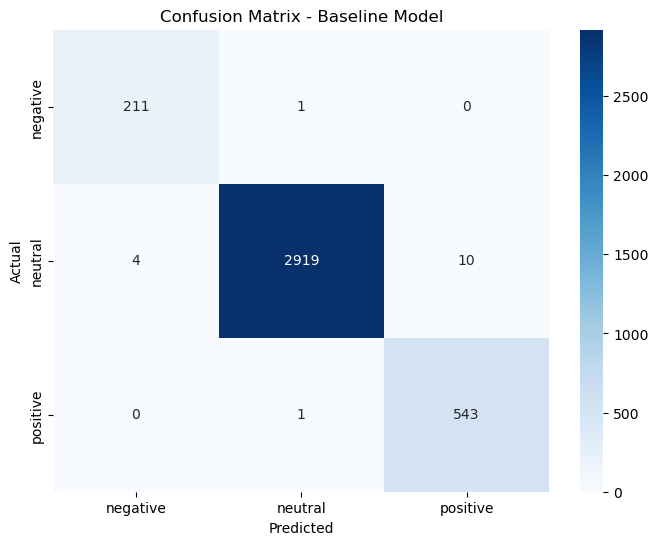

In [46]:
# ===== 8. BASELINE ML MODEL =====
print("\n🤖 Training baseline ML model...")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)

# Predictions
y_pred = lr_model.predict(X_test)

# Evaluation
print("📈 Baseline Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.title('Confusion Matrix - Baseline Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


📊 Generating word frequency charts...


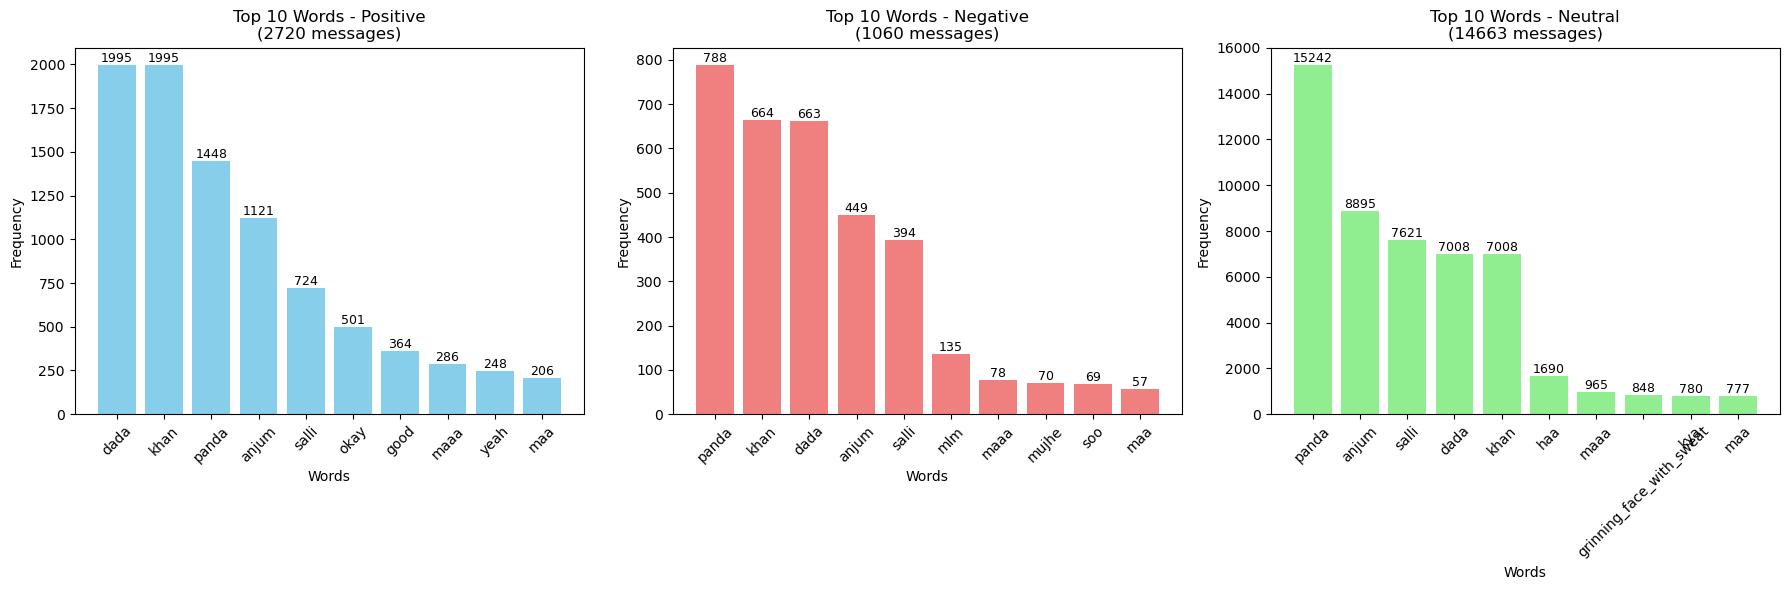


📈 Overall Word Frequency Analysis:
Top 20 Most Frequent Words Overall:
   1. panda          : 17478 occurrences
   2. anjum          : 10465 occurrences
   3. khan           : 9667 occurrences
   4. dada           : 9666 occurrences
   5. salli          : 8739 occurrences
   6. haa            : 1735 occurrences
   7. maaa           : 1329 occurrences
   8. maa            : 1040 occurrences
   9. grinning_face_with_sweat: 975 occurrences
  10. kya            : 882 occurrences
  11. achaa          : 743 occurrences
  12. haan           : 531 occurrences
  13. okay           : 507 occurrences
  14. soo            : 468 occurrences
  15. face_with_tears_of_joy: 443 occurrences
  16. know           : 434 occurrences
  17. bhi            : 417 occurrences
  18. good           : 391 occurrences
  19. bolo           : 386 occurrences
  20. see            : 327 occurrences


In [56]:
# ===== 10. ALTERNATIVE: WORD FREQUENCY CHARTS (if WordCloud fails) =====
print("\n📊 Generating word frequency charts...")

from collections import Counter

sentiments = ['positive', 'negative', 'neutral']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, sentiment in enumerate(sentiments):
    sentiment_messages = df[df['sentiment_label'] == sentiment]['ml_ready_message'].dropna()
    
    if len(sentiment_messages) > 0:
        all_text = ' '.join(sentiment_messages)
        words = all_text.split()
        
        if words:
            # Get top 10 words for this sentiment
            word_freq = Counter(words).most_common(10)
            
            if word_freq:
                words, counts = zip(*word_freq)
                
                # Create bar chart
                bars = axes[i].bar(words, counts, color=['skyblue', 'lightcoral', 'lightgreen'][i])
                axes[i].set_title(f'Top 10 Words - {sentiment.capitalize()}\n({len(sentiment_messages)} messages)')
                axes[i].set_xlabel('Words')
                axes[i].set_ylabel('Frequency')
                axes[i].tick_params(axis='x', rotation=45)
                
                # Add value labels on bars
                for bar, count in zip(bars, counts):
                    height = bar.get_height()
                    axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                                f'{count}', ha='center', va='bottom', fontsize=9)
            else:
                axes[i].text(0.5, 0.5, f'No words to display\nfor {sentiment}', 
                           ha='center', va='center', fontsize=12)
                axes[i].set_title(f'{sentiment.capitalize()} Sentiment')
        else:
            axes[i].text(0.5, 0.5, f'No text content\nin {sentiment} messages', 
                       ha='center', va='center', fontsize=12)
            axes[i].set_title(f'{sentiment.capitalize()} Sentiment')
    else:
        axes[i].text(0.5, 0.5, f'No {sentiment} messages', 
                   ha='center', va='center', fontsize=12)
        axes[i].set_title(f'{sentiment.capitalize()} Sentiment')

plt.tight_layout()
plt.show()

# Overall word frequency
print("\n📈 Overall Word Frequency Analysis:")
all_text = ' '.join(df['ml_ready_message'].dropna())
if all_text.strip():
    all_words = all_text.split()
    overall_freq = Counter(all_words).most_common(20)
    
    print("Top 20 Most Frequent Words Overall:")
    for j, (word, count) in enumerate(overall_freq, 1):
        print(f"  {j:2d}. {word:15s}: {count:3d} occurrences")
else:
    print("No text available for frequency analysis.")


📊 Creating visualizations...


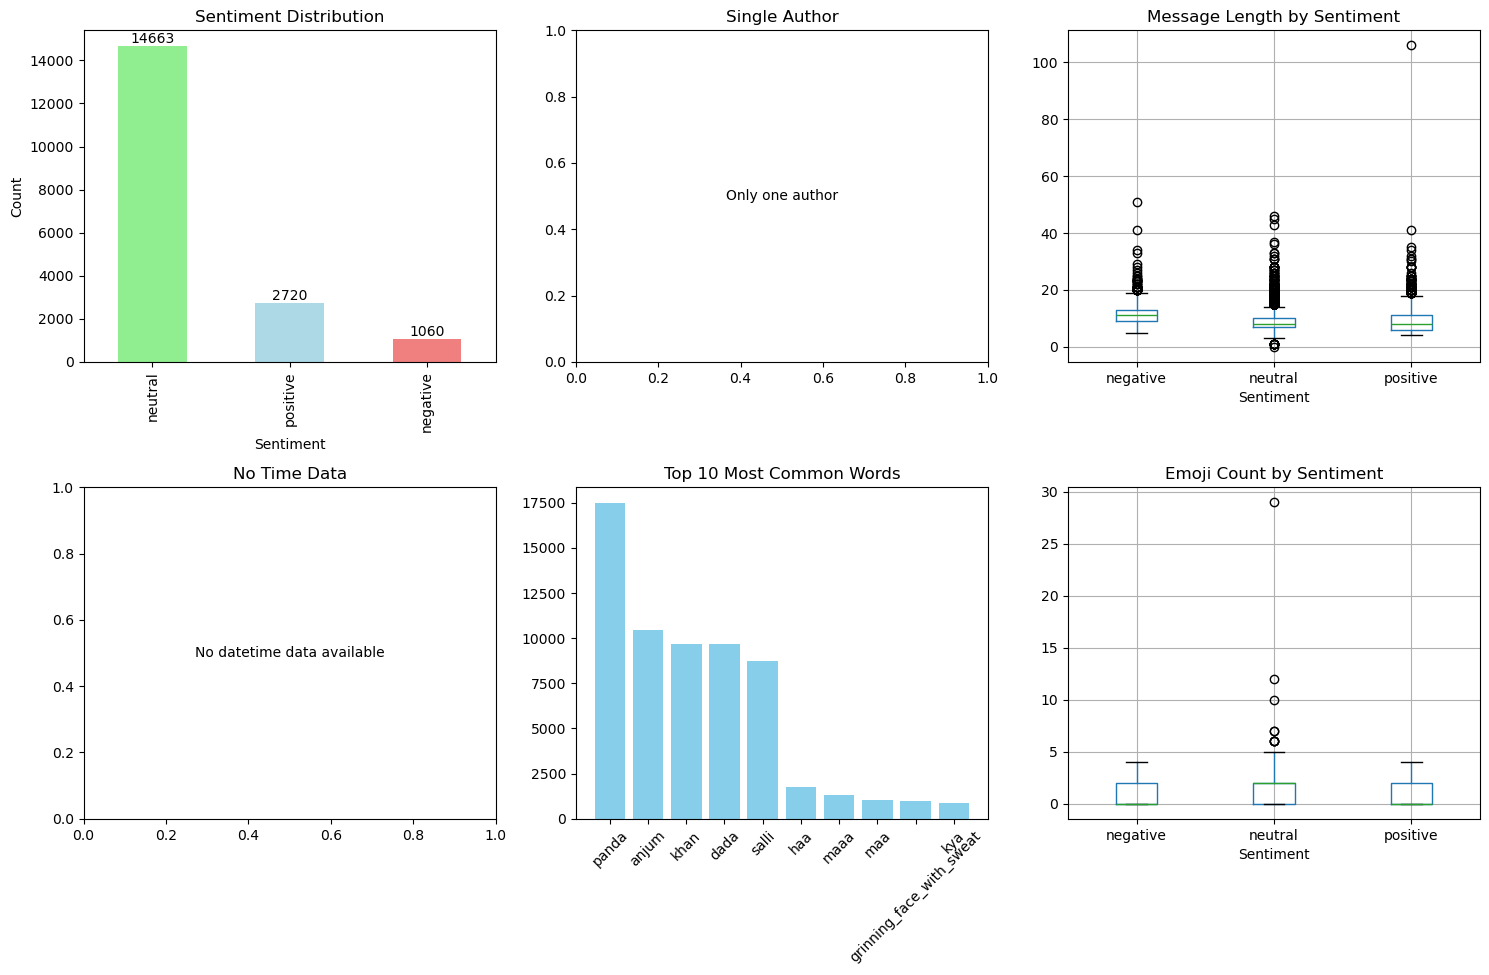

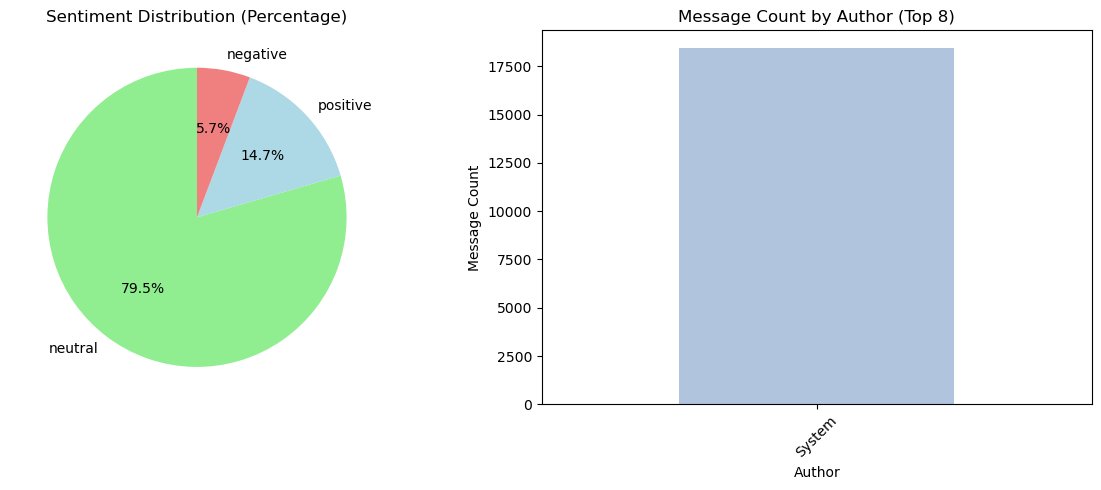

In [58]:
# ===== 9. VISUALIZATIONS =====
print("\n📊 Creating visualizations...")

plt.figure(figsize=(15, 10))

# 1. Sentiment distribution
plt.subplot(2, 3, 1)
sentiment_counts = df['sentiment_label'].value_counts()
colors = ['lightgreen', 'lightblue', 'lightcoral']  # positive, neutral, negative
sentiment_counts.plot(kind='bar', color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
# Add count labels on bars
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

# 2. Sentiment by author
plt.subplot(2, 3, 2)
if len(df['author'].unique()) <= 10 and len(df['author'].unique()) > 1:
    sentiment_by_author = pd.crosstab(df['author'], df['sentiment_label'], normalize='index')
    sentiment_by_author = sentiment_by_author[['positive', 'neutral', 'negative']]  # Ensure consistent order
    sentiment_by_author.plot(kind='bar', stacked=True, ax=plt.gca(), color=colors)
    plt.title('Sentiment Distribution by Author')
    plt.xlabel('Author')
    plt.ylabel('Proportion')
    plt.legend(title='Sentiment')
    plt.xticks(rotation=45)
elif len(df['author'].unique()) == 1:
    plt.text(0.5, 0.5, 'Only one author', ha='center', va='center')
    plt.title('Single Author')
else:
    plt.text(0.5, 0.5, 'Too many authors to display', ha='center', va='center')
    plt.title('Too Many Authors')

# 3. Message length by sentiment
plt.subplot(2, 3, 3)
df.boxplot(column='word_count', by='sentiment_label', ax=plt.gca())
plt.title('Message Length by Sentiment')
plt.suptitle('')  # Remove automatic title
plt.xlabel('Sentiment')

# 4. Sentiment over time (if we have datetime)
plt.subplot(2, 3, 4)
if df['datetime'].notna().any() and len(df) > 1:
    df_sorted = df.sort_values('datetime')
    df_sorted['date'] = pd.to_datetime(df_sorted['date'])
    daily_sentiment = df_sorted.groupby('date')['compound_score'].mean()
    plt.plot(daily_sentiment.index, daily_sentiment.values, marker='o', markersize=2, linewidth=1)
    plt.title('Average Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Compound Score')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No datetime data available', ha='center', va='center')
    plt.title('No Time Data')

# 5. Most common words by sentiment
plt.subplot(2, 3, 5)
try:
    all_words = ' '.join(df['ml_ready_message'].dropna()).split()
    if all_words:
        word_freq = Counter(all_words).most_common(10)
        words, counts = zip(*word_freq)
        plt.bar(words, counts, color='skyblue')
        plt.title('Top 10 Most Common Words')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'No words to display', ha='center', va='center')
        plt.title('No Word Data')
except Exception as e:
    plt.text(0.5, 0.5, 'Error in word analysis', ha='center', va='center')
    plt.title('Word Analysis Error')

# 6. Emoji analysis
plt.subplot(2, 3, 6)
df.boxplot(column='emoji_count', by='sentiment_label', ax=plt.gca())
plt.title('Emoji Count by Sentiment')
plt.suptitle('')  # Remove automatic title
plt.xlabel('Sentiment')

plt.tight_layout()
plt.show()

# Additional visualization: Sentiment percentage pie chart
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sentiment_counts = df['sentiment_label'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Sentiment Distribution (Percentage)')

# Author message count
plt.subplot(1, 2, 2)
author_counts = df['author'].value_counts().head(8)  # Top 8 authors
if len(author_counts) > 0:
    author_counts.plot(kind='bar', color='lightsteelblue')
    plt.title('Message Count by Author (Top 8)')
    plt.xlabel('Author')
    plt.ylabel('Message Count')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No author data', ha='center', va='center')
    plt.title('No Author Data')

plt.tight_layout()
plt.show()

In [60]:
# ===== 11. SAVE MODEL & RESULTS =====
print("\n💾 Saving model and results...")

# Save the model
joblib.dump(lr_model, 'whatsapp_sentiment_model.joblib')
print("✅ Model saved as 'whatsapp_sentiment_model.joblib'")

# Save results to CSV
df.to_csv('whatsapp_chat_with_sentiment.csv', index=False)
print("✅ Results saved as 'whatsapp_chat_with_sentiment.csv'")


💾 Saving model and results...
✅ Model saved as 'whatsapp_sentiment_model.joblib'
✅ Results saved as 'whatsapp_chat_with_sentiment.csv'


In [62]:
# ===== 12. INFERENCE FUNCTION =====
def predict_sentiment(message, model=lr_model):
    """Predict sentiment for a new message"""
    # Clean the message
    clean_msg = clean_whatsapp_text(message)
    ml_ready_msg = advanced_text_cleaning(clean_msg)
    
    # Get VADER scores
    sentiment_scores = get_vader_sentiment(clean_msg)
    
    # Create features
    features = {
        'word_count': len(clean_msg.split()),
        'char_count': len(clean_msg),
        'emoji_count': emoji.emoji_count(message),
        'exclamation_count': message.count('!'),
        'question_count': message.count('?'),
        'uppercase_ratio': sum(1 for c in message if c.isupper()) / max(len(message), 1),
        'positive_score': sentiment_scores['pos'],
        'negative_score': sentiment_scores['neg'],
        'neutral_score': sentiment_scores['neu'],
        'compound_score': sentiment_scores['compound']
    }
    
    # Convert to DataFrame
    features_df = pd.DataFrame([features])
    
    # Predict
    prediction = model.predict(features_df)[0]
    probability = model.predict_proba(features_df)[0]
    
    return {
        'message': message,
        'clean_message': clean_msg,
        'sentiment': prediction,
        'confidence': max(probability),
        'vader_compound': sentiment_scores['compound'],
        'probabilities': dict(zip(model.classes_, probability))
    }


In [64]:
# ===== 13. TEST THE MODEL =====
print("\n🧪 Testing the model with sample messages...")

test_messages = [
    "I love this! It's amazing! 😍",
    "This is terrible and awful 😠",
    "The meeting is at 3 PM tomorrow.",
    "Wow! Fantastic news! 🎉",
    "I'm so disappointed with the service.",
    "The weather is nice today."
]

for msg in test_messages:
    result = predict_sentiment(msg)
    print(f"\n📝 Message: {msg}")
    print(f"   Sentiment: {result['sentiment']} (Confidence: {result['confidence']:.2f})")
    print(f"   VADER Score: {result['vader_compound']:.2f}")



🧪 Testing the model with sample messages...

📝 Message: I love this! It's amazing! 😍
   Sentiment: positive (Confidence: 1.00)
   VADER Score: 0.86

📝 Message: This is terrible and awful 😠
   Sentiment: negative (Confidence: 1.00)
   VADER Score: -0.73

📝 Message: The meeting is at 3 PM tomorrow.
   Sentiment: neutral (Confidence: 0.98)
   VADER Score: 0.00

📝 Message: Wow! Fantastic news! 🎉
   Sentiment: positive (Confidence: 1.00)
   VADER Score: 0.84

📝 Message: I'm so disappointed with the service.
   Sentiment: negative (Confidence: 1.00)
   VADER Score: -0.53

📝 Message: The weather is nice today.
   Sentiment: positive (Confidence: 1.00)
   VADER Score: 0.42


In [66]:
# ===== 14. FINAL SUMMARY =====
print("\n" + "="*50)
print("🎉 WHATSAPP SENTIMENT ANALYSIS COMPLETED!")
print("="*50)

print(f"\n📊 FINAL SUMMARY:")
print(f"• Total messages analyzed: {len(df)}")
print(f"• Sentiment distribution:")
for sentiment in ['positive', 'neutral', 'negative']:
    count = (df['sentiment_label'] == sentiment).sum()
    percentage = (count / len(df)) * 100
    print(f"  - {sentiment.capitalize()}: {count} messages ({percentage:.1f}%)")

print(f"• Most positive author: {df.groupby('author')['compound_score'].mean().idxmax()}")
print(f"• Average sentiment score: {df['compound_score'].mean():.3f}")
print(f"• Model accuracy: {accuracy_score(y_test, y_pred):.3f}")

print(f"\n💡 Files created:")
print(f"  - whatsapp_sentiment_model.joblib (Trained model)")
print(f"  - whatsapp_chat_with_sentiment.csv (Full results)")

print(f"\n🚀 Next steps:")
print(f"  - Analyze specific authors or time periods")
print(f"  - Fine-tune with more advanced models (BERT, Transformers)")
print(f"  - Create a Streamlit dashboard for interactive analysis")


🎉 WHATSAPP SENTIMENT ANALYSIS COMPLETED!

📊 FINAL SUMMARY:
• Total messages analyzed: 18443
• Sentiment distribution:
  - Positive: 2720 messages (14.7%)
  - Neutral: 14663 messages (79.5%)
  - Negative: 1060 messages (5.7%)
• Most positive author: System
• Average sentiment score: 0.033
• Model accuracy: 0.996

💡 Files created:
  - whatsapp_sentiment_model.joblib (Trained model)
  - whatsapp_chat_with_sentiment.csv (Full results)

🚀 Next steps:
  - Analyze specific authors or time periods
  - Fine-tune with more advanced models (BERT, Transformers)
  - Create a Streamlit dashboard for interactive analysis
